# Compare Angular Grids
| Author  | Stanley A. Baronett  |
|---------|----------------------|
| Created |  03/18/2024          |
| Updated |  03/18/2024          |

## YFJ's Version ([`149454e`](https://github.com/yanfeij/athena_master/commit/149454ee76c5868288fcca6e478bfe5e7862c253))

In [1]:
#===============================================================================
# // nzeta is number of zeta angles in one quadrant, between 0 and pi
# // npsi is the number of psi angles between 0 and pi
# void NRRadiation::AngularGrid(int angle_flag, int nzeta, int npsi) {
#   MeshBlock *pmb=pmy_block;
#   ...
#   else if (angle_flag == 1) {
# // First and last zeta angles align to north and south poles
import numpy as np

def GetCoszeta_v(nzeta = 1, npsi = 2, polar_angle = True, diag = False):
    nang = 4*npsi*nzeta + 2

    coszeta_max = 1.0
    if polar_angle:
        coszeta_max = (float(nang) - 2)/float(nang)
    
    # // separate ghost zones and active zones
    # // so that they can be compatible with different angular scheme
    if (nzeta > 0):
        coszeta_v = np.empty(2*nzeta)
        coszeta_f = np.empty(2*nzeta+1)
        len_zeta = np.empty(2*nzeta) # // This id Delta (cos\theta)

    zs = 0 # ze = 2*nzeta - 1
    Sum = 0
    dcoszeta = coszeta_max/nzeta
    coszeta_f[zs] = coszeta_max
    for i in range(1, nzeta, 1):
        coszeta_f[i+zs] = coszeta_max - i *dcoszeta
    
    coszeta_f[nzeta+zs] = 0.0
    for i in range(nzeta+1, 2*nzeta+1, 1):
        coszeta_f[i+zs] = -coszeta_f[2*nzeta-i+zs]
        
    for i in range(0, nzeta, 1):
        coszeta_v[i+zs] = 0.5*(coszeta_f[i+zs]+coszeta_f[i+zs+1])
        Sum += np.power(coszeta_v[i+zs], 2)

    if diag:
        print(f'dcoszeta = {dcoszeta}')
        print(f'coszeta_f = {coszeta_f}')
        print(f'coszeta_v[:nzeta] = {coszeta_v[:nzeta]}')

    # // re-normalize
    Sum *= 2*npsi
    normalization = np.sqrt((nang/3 - 2)/Sum)
    # normalization = 2*nzeta/np.sqrt(4*nzeta*nzeta-1)

    # // need to change this later
    if not polar_angle:

        for i in range(0, nzeta, 1):
            coszeta_v[i+zs] *= normalization



    for i in range(nzeta, 2*nzeta, 1):
        coszeta_v[i+zs] = -coszeta_v[2*nzeta-i-1+zs]
      
    
    for i in range(0, nzeta*2, 1):
        len_zeta[i] = coszeta_f[i] - coszeta_f[i+1]

    if diag:
        print(f'Sum = {Sum}')
        print(f'nang = {nang}')
        print(f'normalization = {normalization}')

    return coszeta_v

In [2]:
npsi = 2
nzeta = 2
GetCoszeta_v(nzeta, npsi, diag = True)

dcoszeta = 0.4444444444444444
coszeta_f = [ 0.88888889  0.44444444  0.         -0.44444444 -0.88888889]
coszeta_v[:nzeta] = [0.66666667 0.22222222]
Sum = 1.9753086419753085
nang = 18
normalization = 1.4230249470757708


array([ 0.66666667,  0.22222222, -0.22222222, -0.66666667])

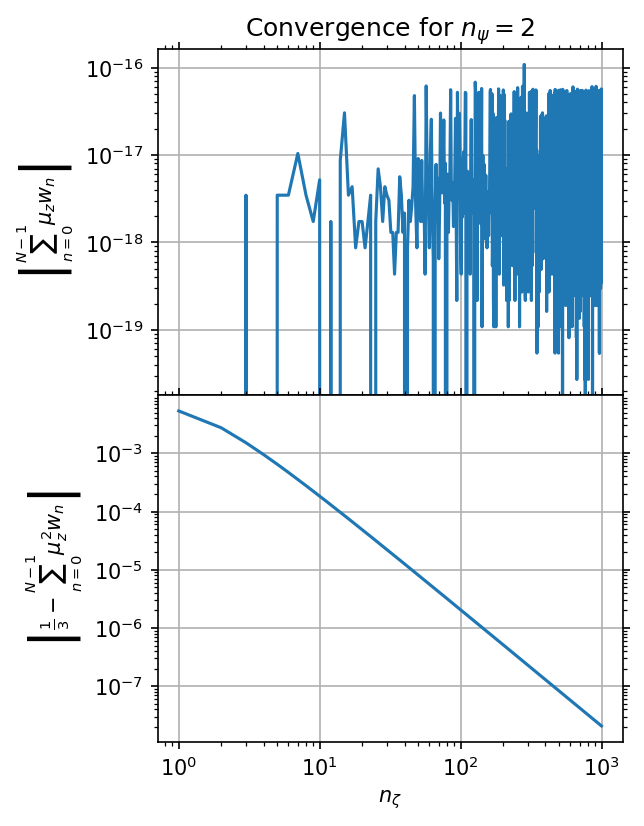

In [3]:
#===============================================================================
import matplotlib.pyplot as plt

diag = False

# Compute moment sums
npsi = 2
nzetas = range(1, 1000, 1)
mom1sums = np.zeros(len(nzetas))
mom2sums = np.zeros(len(nzetas))

for z,nzeta in enumerate(nzetas):
    nang = 2*npsi*2*nzeta + 2
    w = 1.0/nang
    mom1sum = 0
    mom2sum = 0
    mom1sum += 1.0*w -1.0*w # start with north and south poles
    mom2sum += 2*w
    coszeta_v = GetCoszeta_v(nzeta, npsi)

    for i in range(0, 2*npsi, 1):
        for j in range(0, 2*nzeta, 1):
            mom1sum += coszeta_v[j]*w
            mom2sum += coszeta_v[j]**2*w

    mom1sums[z] = mom1sum
    mom2sums[z] = mom2sum

    if diag:
        print(f'nang = {nang}')
        print(f'1st moment sum: {mom1sum}')
        print(f'2nd moment sum: {mom2sum}')

# Plot error vs. nzeta
fig, axs = plt.subplots(nrows=2, figsize=(4, 6), dpi=150)

axs[0].plot(nzetas, np.abs(mom1sums))
axs[1].plot(nzetas, np.abs(mom2sums - 1/3))

# Format (sub)plots
for ax in axs:
    ax.grid()
    ax.minorticks_on()
    ax.set(yscale='log', xscale='log')
    ax.tick_params(axis='both', which='both', top=True, right=True)

axs[0].set(title=f'Convergence for $n_\psi = {npsi}$',
           ylabel=r'$\left|\sum_{n=0}^{N-1}\mu_z w_n\right|$')
axs[1].set(xlabel=r'$n_\zeta$',
           ylabel=r'$\left|\frac{1}{3} - \sum_{n=0}^{N-1}\mu_z^2w_n\right|$')
plt.subplots_adjust(hspace=0.0)

## My Version
### $n_\zeta$ excludes poles

Let $n_\zeta \in \Bbb{N}$ define the number of polar angles $0 < \zeta < \pi$ per azimuthal range $\Delta\psi$ (e.g., orange slice) and $n_\psi \in \Bbb{N}$ define the number of azimuthal angles $0 < \psi < \pi$.
Note, these angles do not include the two default rays along the north and south poles, aligned parallel and antiparallel to the $\hat r$ direction, respectively, in spherical-polar coorinates.

If $\zeta_1^\mathrm{f}$ defines the polar angle of the cell interface that bounds the solid angle subtended by the north pole, then
\begin{align*}
    \int \mathrm{d}\Omega &= \int_0^{2\pi}\mathrm{d}\psi\int_0^{\zeta_1^\mathrm{f}}\sin\zeta\mathrm{d}\zeta \\
    \Omega &= 2\pi\left(1 - \cos\zeta_1^\mathrm{f}\right).
    \tag{A}
\end{align*}
Meanwhile, the solid angle subtended by any mid-latitude ray (between the poles), where $0 < \zeta_i^\mathrm{f} < \pi$ defines the $n_\zeta + 1$ cell interfaces, is
\begin{equation*}
    \Omega = \frac{\pi}{n_\psi}\left(\cos\zeta_i^\mathrm{f} - \cos\zeta_{i+1}^\mathrm{f}\right),
    \tag{B}
\end{equation*}
for $i \in \Bbb{N}$ and $1 \leq i < n_\zeta + 1$.
For $2n_\psi n_\zeta + 2$ equivalent solid angles subtended by unique cell-centered rays $\zeta_i^\mathrm{v}$ where 
\begin{equation*}
    \cos\zeta_i^\mathrm{v} = \frac{\cos\zeta_i^\mathrm{f} + \cos\zeta_{i+1}^\mathrm{f}}{2},
\tag{C}
\end{equation*}
we find
\begin{align*}
    (2n_\psi n_\zeta + 2)\Omega &= 2\pi\left(1 - \cos\zeta_1^\mathrm{f}\right) + 2n_\psi n_\zeta\frac{\pi}{n_\psi}\left(\cos\zeta_i^\mathrm{f} - \cos\zeta_{i+1}^\mathrm{f}\right) + 2\pi\left(\cos\zeta_{i+1}^\mathrm{f} + 1\right) \\
    \Omega &= \frac{2\pi}{n_\psi n_\zeta + 1}.
    \tag{D}
\end{align*}
Combining equations (A) and (D) yields
\begin{equation*}
    \cos\zeta_1^\mathrm{f} = \frac{n_\psi n_\zeta}{n_\psi n_\zeta + 1}.
    \tag{E}
\end{equation*}
If $\Delta\cos\zeta \equiv \cos\zeta_i^\mathrm{f} - \cos\zeta_{i+1}^\mathrm{f}$, then combining equations (B) and (D) yields
\begin{equation*}
    \Delta\cos\zeta = \frac{2n_\psi}{n_\psi n_\zeta + 1}.
    \tag{F}
\end{equation*}
Thus,
\begin{equation*}
    \cos\zeta_{i+1}^\mathrm{f} = \cos\zeta_1^\mathrm{f} - i\Delta\cos\zeta.
    \tag{G}
\end{equation*}

### Re-normalization

To ensure eq. (11) of Jiang ([2021](https://ui.adsabs.harvard.edu/abs/2021ApJS..253...49J/abstract)) is satisfied, we must solve for the renormalization factor $b$.
With $w_n = 1/N$, we find:
\begin{align*}
    \sum_{n=0}^{N-1} \mu_{n,\,z}^2w_n = 2w_n + \sum_{n=1}^{N-2} (b\cos\zeta_n^\mathrm{v})^2w_n &= \frac{1}{3} \\
    \sum_{n=0}^{N-1} (\cos\zeta_n^\mathrm{v})^2 &= \frac{N}{3b^2} \\
    b &= \left(\frac{N}{3\sum_{n=0}^{N-1} (\cos\zeta_n^\mathrm{v})^2}\right)^{1/2},
\end{align*}
where, from equations (C),
\begin{equation*}
    \cos\zeta_n^\mathrm{v} = \frac{\cos\zeta_n^\mathrm{f} + \cos\zeta_{n+1}^\mathrm{f}}{2}
\end{equation*}.
With $\cos\zeta_n^\mathrm{f} = 1 - n\Delta\cos\zeta$,
\begin{align*}
    \cos\zeta_n^\mathrm{v} &= \frac{1 - n\Delta\cos\zeta + 1 - (n + 1)\Delta\cos\zeta}{2} \\
\end{align*}

In [4]:
#===============================================================================
# // nzeta is number of zeta angles in one quadrant, between 0 and pi
# // npsi is the number of psi angles between 0 and pi
# void NRRadiation::AngularGrid(int angle_flag, int nzeta, int npsi) {
#   MeshBlock *pmb=pmy_block;
#   ...
#   else if (angle_flag == 2) {
# // First and last zeta angles align to north and south poles
import numpy as np

def GetCoszeta_v(nzeta = 1, npsi = 2, diag = False):
    coszeta_v = np.empty(2*nzeta)
    coszeta_f = np.empty(2*nzeta+1)

    zs = 0 # ze = 2*nzeta - 1
    Sum = 0
    dcoszeta = npsi/(npsi*nzeta + 1)
    coszeta_f[zs] = npsi*nzeta/(npsi*nzeta + 1)
    for i in range(0, 2*nzeta, 1):
        coszeta_f[i+zs+1] = coszeta_f[zs] - (i+1)*dcoszeta
        coszeta_v[i+zs] = 0.5*(coszeta_f[i+zs] + coszeta_f[i+zs+1])
        Sum += np.power(coszeta_v[i+zs], 2)

    if diag:
        print(f'dcoszeta = {dcoszeta}')
        print(f'coszeta_f = {coszeta_f}')
        print(f'coszeta_v = {coszeta_v}')

    # re-normalize
    Sum *= 2*npsi
    nang = 2*npsi*2*nzeta + 2
    normalization = np.sqrt((nang/3 - 2)/Sum)

    for i in range(0, 2*nzeta, 1):
        coszeta_v[i+zs] *= normalization

    if diag:
        print(f'Sum = {Sum}')
        print(f'nang = {nang}')
        print(f'normalization = {normalization}')

    return coszeta_v

In [5]:
npsi = 2
nzeta = 2
GetCoszeta_v(nzeta, npsi, diag = True)

dcoszeta = 0.4
coszeta_f = [ 0.8  0.4  0.  -0.4 -0.8]
coszeta_v = [ 0.6  0.2 -0.2 -0.6]
Sum = 3.200000000000001
nang = 18
normalization = 1.1180339887498947


array([ 0.67082039,  0.2236068 , -0.2236068 , -0.67082039])

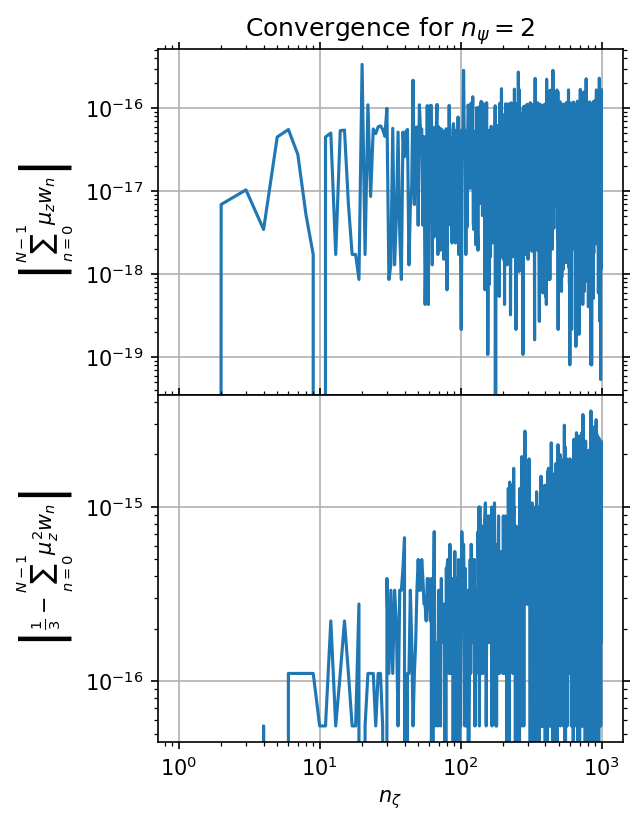

In [6]:
#===============================================================================
import matplotlib.pyplot as plt

diag = False

# Compute moment sums
npsi = 2
nzetas = range(1, 1000, 1)
mom1sums = np.zeros(len(nzetas))
mom2sums = np.zeros(len(nzetas))

for z,nzeta in enumerate(nzetas):
    nang = 2*npsi*2*nzeta + 2
    w = 1.0/nang
    mom1sum = 0
    mom2sum = 0
    mom1sum += 1.0*w -1.0*w # start with north and south poles
    mom2sum += 2*w
    coszeta_v = GetCoszeta_v(nzeta, npsi)

    for i in range(0, 2*npsi, 1):
        for j in range(0, 2*nzeta, 1):
            mom1sum += coszeta_v[j]*w
            mom2sum += coszeta_v[j]**2*w

    mom1sums[z] = mom1sum
    mom2sums[z] = mom2sum

    if diag:
        print(f'nang = {nang}')
        print(f'1st moment sum: {mom1sum}')
        print(f'2nd moment sum: {mom2sum}')

# Plot error vs. nzeta
fig, axs = plt.subplots(nrows=2, figsize=(4, 6), dpi=150)

axs[0].plot(nzetas, np.abs(mom1sums))
axs[1].plot(nzetas, np.abs(mom2sums - 1/3))

# Format (sub)plots
for ax in axs:
    ax.grid()
    ax.minorticks_on()
    ax.set(yscale='log', xscale='log')
    ax.tick_params(axis='both', which='both', top=True, right=True)

axs[0].set(title=f'Convergence for $n_\psi = {npsi}$',
           ylabel=r'$\left|\sum_{n=0}^{N-1}\mu_z w_n\right|$')
axs[1].set(xlabel=r'$n_\zeta$',
           ylabel=r'$\left|\frac{1}{3} - \sum_{n=0}^{N-1}\mu_z^2w_n\right|$')
plt.subplots_adjust(hspace=0.0)